# Butterfly Dataset example

In [9]:
import numpy as np
import pandas as pd
# from typing import List

import matplotlib.pyplot as plt
import seaborn as sns
# from IPython.display import display

# from scipy.stats import ks_2samp, chi2_contingency
from scipy.spatial.transform import Rotation
from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import roc_auc_score
# from sklearn.decomposition import PCA

import nannyml as nml

# Creating Butterfly Dataset

By butterfly dataset we mean a dataset that does not drift at the univariate level but changes in it's overall stucture.

In [2]:
# 10 reference periods
# 10 analysis periods
# Days/week * Hours/day * events/hour
DPP = 7*24*12

np.random.seed(13)
s1 = np.random.randn(DPP*20)
x1 = s1 + np.random.randn(DPP*20)/8
x2 = s1 + np.random.randn(DPP*20)/8
x3 = np.random.randn(DPP*20)/8
xdat = np.array([x1, x2, x3]).T

rot = Rotation.from_euler('z', 90, degrees=True)

# following proper matrix multiplication rules, we need a 3xN data matrix
ydat = np.matmul(rot.as_matrix(), xdat.T).T

# create overall array that has drifted and not drifted subsets.
dataar = np.concatenate(
    (xdat[:-5*DPP], ydat[-5*DPP:]),
    axis=0
)

# convert data to dataframe
datadf = pd.DataFrame(dataar, columns=['f1', 'f2', 'f3'])

# add "timestamp" column
datadf = datadf.assign(ordered = pd.date_range(start='1/6/2020', freq='5min', periods=20*DPP))

# Adding helper column - duplicates date range functionality
datadf['week'] = datadf.ordered.dt.isocalendar().week - 1
# Adding partition column
datadf['partition'] = 'reference'
datadf.loc[datadf.week >= 11, ['partition']] = 'analysis'

# Assign random predictions and targets (we won't be using them but they are needed for NannyML)
datadf = datadf.assign(y_pred = np.random.rand(DPP*20))
datadf = datadf.assign(y_true = np.random.randint(2, size=DPP*20))

In [3]:
datadf

,f1,f2,f3,ordered,week,partition,y_pred,y_true
0,-0.575988,-0.784756,-0.098682,2020-01-06 00:00:00,1,reference,0.777597,0
1,0.807732,0.449399,-0.143667,2020-01-06 00:05:00,1,reference,0.614255,0
2,-0.259404,-0.087723,0.044293,2020-01-06 00:10:00,1,reference,0.840156,0
3,0.509505,0.302523,0.123148,2020-01-06 00:15:00,1,reference,0.134257,1
4,1.344713,1.288776,0.147263,2020-01-06 00:20:00,1,reference,0.935788,1
...,...,...,...,...,...,...,...,...
40315,1.582374,-1.746059,-0.011009,2020-05-24 23:35:00,20,analysis,0.815969,1
40316,-1.165544,1.193032,-0.071487,2020-05-24 23:40:00,20,analysis,0.021468,1
40317,1.197175,-1.225043,-0.228337,2020-05-24 23:45:00,20,analysis,0.654150,0
40318,0.254132,-0.076570,0.124199,2020-05-24 23:50:00,20,analysis,0.220050,1


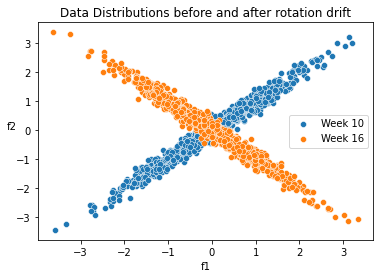

In [5]:
# Let's Visualize
sns.scatterplot(
    x=datadf.loc[datadf.week == 10, 'f1'][:1000],
    y=datadf.loc[datadf.week == 10, 'f2'][:1000],
    label='Week 10'
)
sns.scatterplot(
    x=datadf.loc[datadf.week == 16, 'f1'][:1000],
    y=datadf.loc[datadf.week == 16, 'f2'][:1000],
    label='Week 16'
)
plt.title('Data Distributions before and after rotation drift')
plt.xlabel('f1')
plt.ylabel('f2', rotation=0)
plt.legend()
plt.savefig('butterfly-scatterplot.jpg')

In [17]:
reference = datadf.loc[datadf['partition'] == 'reference'].reset_index(drop=True)
reference.drop(['week'], axis=1, inplace=True)
analysis = datadf.loc[datadf['partition'] == 'analysis'].reset_index(drop=True)
analysis.drop(['y_true', 'week'], axis=1, inplace=True)
analysis

,f1,f2,f3,ordered,partition,y_pred
0,1.169372,1.246261,-0.187868,2020-03-16 00:00:00,analysis,0.502341
1,0.355603,0.450899,-0.205080,2020-03-16 00:05:00,analysis,0.313641
2,1.985816,1.930140,0.089422,2020-03-16 00:10:00,analysis,0.779716
3,0.024558,-0.076617,-0.017228,2020-03-16 00:15:00,analysis,0.096362
4,-0.902870,-0.832674,0.012715,2020-03-16 00:20:00,analysis,0.758182
...,...,...,...,...,...,...
20155,1.582374,-1.746059,-0.011009,2020-05-24 23:35:00,analysis,0.815969
20156,-1.165544,1.193032,-0.071487,2020-05-24 23:40:00,analysis,0.021468
20157,1.197175,-1.225043,-0.228337,2020-05-24 23:45:00,analysis,0.654150
20158,0.254132,-0.076570,0.124199,2020-05-24 23:50:00,analysis,0.220050


In [18]:
md = nml.extract_metadata(data = reference, model_name='wfh_predictor')
md.identifier_column_name = 'ordered'
md.timestamp_column_name = 'ordered'
md.ground_truth_column_name = 'y_true'
print(md.print())

Metadata for model wfh_predictor

# Warning - unable to identify all essential data
# Please identify column names for all '~ UNKNOWN ~' values

Model problem             binary_classification    

Identifier column         ordered                  
Timestamp column          ordered                  
Partition column          partition                
Prediction column         y_pred                   
Ground truth column       y_true                   

Features

Name                 Column               Type            Description
f1                   f1                   continuous      extracted feature: f1
f2                   f2                   continuous      extracted feature: f2
f3                   f3                   continuous      extracted feature: f3


In [19]:
univariate_calculator = nml.UnivariateStatisticalDriftCalculator(model_metadata=md, chunk_size=DPP)

In [20]:
univariate_calculator.fit(reference_data=reference)
univariate_results = univariate_calculator.calculate(data=pd.concat([reference, analysis], ignore_index=True))

In [ ]:
plots = nml.DriftPlots(md)
plots.plot_univariate_statistical_drift(univariate_results, metric='statistic', feature_label='f1').show()

In [21]:
rcerror_calculator = nml.DataReconstructionDriftCalculator(model_metadata=md, chunk_size=DPP)
rcerror_calculator.fit(reference_data=reference)
rcerror_results = rcerror_calculator.calculate(data=pd.concat([reference, analysis], ignore_index=True))

In [ ]:
plots.plot_data_reconstruction_drift(rcerror_results).show()